Exercises RNNs
==============



## Acknowledgment and Overview



This exercise is based on the Pytorch Tutorial

[https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

We will first got trough it, and then explore the issue of **exploding gradients**
with it. Finally, you should implement gradient clipping.



## Introduction



Our **goal** is to build and train a basic **character-level RNN** to classify words.
A character-level RNN reads words as a series of characters - outputting a prediction and “hidden state” at each step, feeding its previous hidden state into each next step.
We take the final prediction to be the output, i.e. which class the word belongs to.
Specifically, we’ll train on a few thousand surnames from 18 languages of origin, and predict which language a name is from based on the spelling. This is an instance of a **many-to-one** model.

Preprocessing for NLP (Natural Language Processing) modeling  is done from “from scratch”.
In particular we are not  using many of the convenience functions of `torchtext`.



## Prepare Data



Download the data from
[https://download.pytorch.org/tutorial/data.zip](https://download.pytorch.org/tutorial/data.zip)
Extract the data in the current directory.

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names &#x2026;]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.



In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

print(category_lines['German'][:10])

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']
['Abbing', 'Abel', 'Abeln', 'Abt', 'Achilles', 'Achterberg', 'Acker', 'Ackermann', 'Adam', 'Adenauer']


To represent a single letter, we use a **one-hot vector** of size $1 \times n_{letters}$. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 &#x2026;>.

To make a word we join a bunch of those into a 2D matrix $line_{length} \times  1 \times  n_{letters}$.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.



In [3]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


## RNN



The architecture of this  RNN is shown in Figure [2](#orga1e3e26). The input and the hidden state are concatenated and
are used as the input for two feed-forward networks. One maps to the (new) hidden state, and one to
the output. The latter is passed through a soft-max layer.

![img](rnn_ex.png "Architecture of model")



In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

input = lineToTensor('Steffen')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8787, -2.9631, -2.9020, -2.8892, -2.8092, -2.9111, -2.8074, -2.9600,
         -2.9534, -2.9452, -2.8847, -2.8478, -2.9356, -2.8175, -2.9136, -2.8567,
         -2.8019, -2.9788]], grad_fn=<LogSoftmaxBackward0>)


## Training



Before going into training we should make a few helper functions. The first is to interpret the output of the network,
which we know to be a likelihood of each category. We can use `Tensor.topk` to get the index of the greatest value:



In [5]:
input = lineToTensor('Mayer')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

tensor([[-2.8320, -2.8377, -2.9220, -2.9041, -2.8823, -2.9442, -2.9041, -2.9138,
         -2.9390, -2.9635, -2.8991, -2.8613, -2.8794, -2.8541, -2.9600, -2.8048,
         -2.8528, -2.8898]], grad_fn=<LogSoftmaxBackward0>)
('Dutch', 15)


A quick way to get a training example (a name and its language):



In [6]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Vietnamese / line = Thuy
category = Greek / line = Garofalis
category = Spanish / line = Robles
category = Italian / line = De santis
category = Russian / line = Turyanov
category = Japanese / line = Sada
category = Russian / line = Hizhnyak
category = Scottish / line = Dickson
category = German / line = Ott
category = Greek / line = Giannakopoulos


Each loop of training will:

-   Create input and target tensors
-   Create a zeroed initial hidden state
-   Read each letter in and
-   Keep hidden state for next letter
-   Compare final output to target
-   Back-propagate
-   Return the output and loss



In [7]:
#n_hidden = 128
#rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

In [8]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [9]:
current_loss = 0
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

torch.save(rnn, 'char-rnn-classification.pt')

5000 5% (0m 7s) 2.6845 Schwartz / Spanish ✗ (Czech)
10000 10% (0m 15s) 2.3309 Vargas / Greek ✗ (Portuguese)
15000 15% (0m 23s) 2.3998 Wruck / Czech ✗ (German)
20000 20% (0m 30s) 2.0084 Campos / Greek ✗ (Portuguese)
25000 25% (0m 39s) 1.9566 Mclaughlin / Irish ✗ (Scottish)
30000 30% (0m 47s) 1.8906 Abadi / Japanese ✗ (Arabic)
35000 35% (0m 55s) 3.7084 Maas / Arabic ✗ (Dutch)
40000 40% (1m 4s) 0.3451 Erizawa / Japanese ✓
45000 45% (1m 12s) 1.0267 Sokal / Polish ✓
50000 50% (1m 19s) 0.7557 Do / Vietnamese ✓
55000 55% (1m 27s) 0.0840 Eliopoulos / Greek ✓
60000 60% (1m 34s) 0.0062 Kouropoulos / Greek ✓
65000 65% (1m 41s) 0.6160 Rigatos / Greek ✓
70000 70% (1m 49s) 3.2126 Weiss / Greek ✗ (Czech)
75000 75% (1m 56s) 2.7584 Lucas / Greek ✗ (Dutch)
80000 80% (2m 4s) 1.2432 Ophoven / Dutch ✓
85000 85% (2m 11s) 0.0274 Antonakos / Greek ✓
90000 90% (2m 19s) 1.7519 Palomo / Italian ✗ (Spanish)
95000 95% (2m 26s) 0.6006 Poniros / Greek ✓
100000 100% (2m 34s) 1.7021 Froy / Scottish ✗ (English)


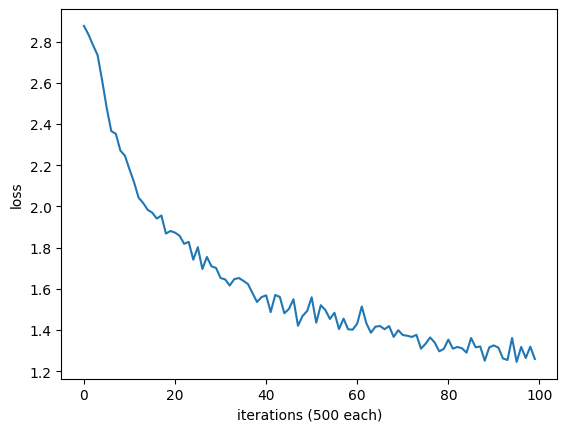

In [10]:
plt.plot(all_losses)
plt.ylabel("loss")
plt.xlabel("iterations (500 each)")
plt.show()

## Evaluation



You may want to load the rnn.



In [11]:
rnn = torch.load('char-rnn-classification.pt')

To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.



In [12]:
# Just return an output given a line
def evaluate(rnn, line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

/var/folders/hp/8j_9m675773gg6qcgy68_sz40000gn/T/ipykernel_73180/4255361430.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
/var/folders/hp/8j_9m675773gg6qcgy68_sz40000gn/T/ipykernel_73180/4255361430.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


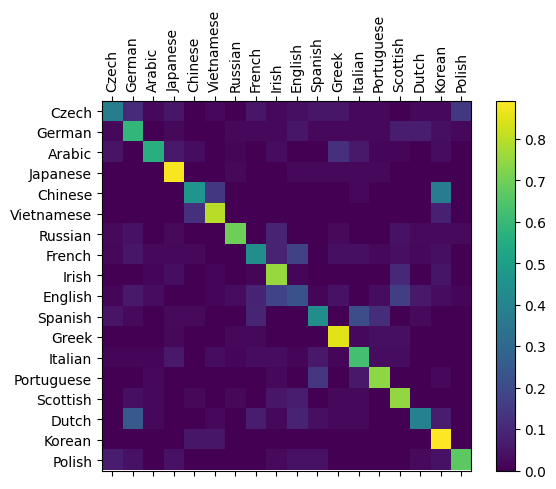

In [13]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 1000

# Go through a bunch of examples and record which are correctly guessed

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(rnn, line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

For example Spanish is close to Portuguese or Italian .



## Running on user input



In [14]:
rnn = torch.load('char-rnn-classification.pt')

def predict(rnn, input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(rnn, lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict(rnn, 'Mc Ruder')
predict(rnn, 'Klinsmann')
predict(rnn, 'Mayer')


> Mc Ruder
(-0.34) Scottish
(-1.91) German
(-3.01) Dutch

> Klinsmann
(-0.43) Scottish
(-2.24) German
(-2.46) Dutch

> Mayer
(-1.10) German
(-2.04) French
(-2.16) Irish


## TASK: Exploding Gradient



The choice of the learning rate is critical.
As mentioned, choosing it too large can lead to an **exploding** gradient.
Increase the learning rate to $0.05$ and monitor the gradient norm.
You have to override the `train` function and use the following function



In [15]:
def compute_gradient_norm(parameters, norm_type=2):
    return torch.norm(
        torch.stack([torch.norm(p.grad.detach(), norm_type) for p in parameters]), norm_type)

To see the effect run it 25000 iterations and plot the gradient norm. What happens to your loss?

To solve the issue, use **gradient clipping**, that is we simply truncate the gradient Norm
at a certain value (below we use one). See 8.5.5 of *Dive into Deep Learning* to
read more about that topic: [https://d2l.djl.ai/chapter_recurrent-neural-networks/rnn-scratch.html](https://d2l.djl.ai/chapter_recurrent-neural-networks/rnn-scratch.html).

Here is a code snippet to clip the gradient to `clipping_value`:



In [16]:
clipping_value = 1
torch.nn.utils.clip_grad_norm_(rnn.parameters(), clipping_value)

tensor(0.)

### Solution



In [17]:
def train(optimizer, category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    clipping_value = 1 # arbitrary value of your choosing
    gradient_norm.append(compute_gradient_norm(rnn.parameters()))
    optimizer.step()
    return output, loss.item()

def run(n_iters, learning_rate, train_func):
    print(f'Learning rate={learning_rate}')
    optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

    print_every = 5000
    plot_every = 1000

    # Keep track of losses for plotting
    current_loss = 0
    all_losses = []

    for iter in range(1, n_iters + 1):
        category, line, category_tensor, line_tensor = randomTrainingExample()
        output, loss = train_func(optimizer, category_tensor, line_tensor)
        current_loss += loss

        # Print iter number, loss, name and guess
        if iter % print_every == 0:
            guess, guess_i = categoryFromOutput(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

        # Add current loss avg to list of losses
        if iter % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0
    return all_losses

In [18]:
start = time.time()
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)
gradient_norm = list()
loss = run(20000, 0.05, train)

Learning rate=0.05
5000 25% (0m 8s) nan Gauk / Czech ✗ (Chinese)
10000 50% (0m 16s) nan Douglas / Czech ✗ (Scottish)
15000 75% (0m 24s) nan Guo / Czech ✗ (Chinese)
20000 100% (0m 33s) nan Hor / Czech ✗ (Chinese)


In [19]:
print(loss)

[2.6566878494620325, 2.3059794544577596, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]


The gradient norm:



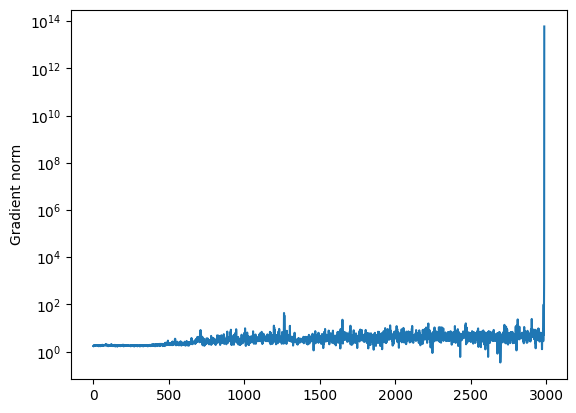

In [20]:
plt.plot(gradient_norm)
plt.yscale('log')
plt.ylabel("Gradient norm");

In [21]:
def train_clipping(optimizer, category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()
    clipping_value = 1 # arbitrary value of your choosing
    gradient_norm.append(compute_gradient_norm(rnn.parameters()))
    torch.nn.utils.clip_grad_norm_(rnn.parameters(), clipping_value)
    optimizer.step()
    return output, loss.item()

In [22]:
n_hidden = 128

rnn = RNN(n_letters, n_hidden, n_categories)
gradient_norm = list()
loss = run(100000, 0.05, train_clipping)

Learning rate=0.05
5000 5% (0m 43s) 2.9341 Caiazzo / Spanish ✗ (Italian)
10000 10% (0m 52s) 1.2937 Vinci / Italian ✓
15000 15% (1m 1s) 2.9993 O'Bree / English ✗ (Irish)
20000 20% (1m 10s) 0.4909 Cui / Chinese ✓
25000 25% (1m 18s) 3.2942 Prill / Scottish ✗ (Czech)
30000 30% (1m 27s) 0.9361 Ferraro / Italian ✓
35000 35% (1m 36s) 0.8034 Ho / Vietnamese ✗ (Korean)
40000 40% (1m 44s) 0.8389 Ramires / Portuguese ✓
45000 45% (1m 53s) 0.2651 Abragamson / Russian ✓
50000 50% (2m 2s) 1.8606 Ludgrove / French ✗ (English)
55000 55% (2m 10s) 0.5190 Daviau / French ✓
60000 60% (2m 19s) 0.0046 Xian / Chinese ✓
65000 65% (2m 27s) 0.0107 Filipowski / Polish ✓
70000 70% (2m 36s) 1.7050 Obando / Irish ✗ (Spanish)
75000 75% (2m 46s) 4.6804 Andruzsky / Polish ✗ (Russian)
80000 80% (2m 56s) 0.5063 Durand / French ✓
85000 85% (3m 4s) 0.0047 Zhan / Chinese ✓
90000 90% (3m 13s) 0.0262 Ku / Korean ✓
95000 95% (3m 22s) 0.3561 Bahmetoff / Russian ✓
100000 100% (3m 31s) 1.0115 De la cruz / Portuguese ✗ (Spanish)


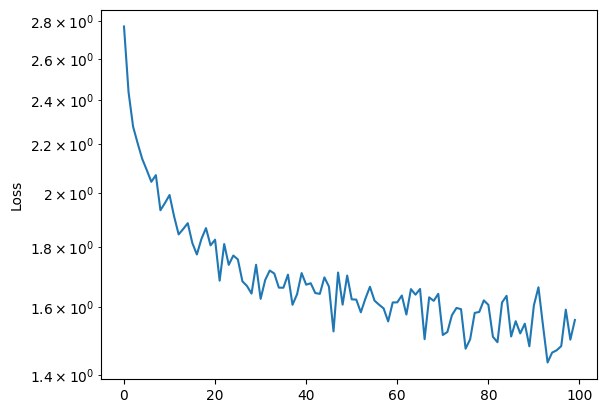

In [23]:
plt.plot(loss)
plt.yscale('log')
plt.ylabel("Loss");

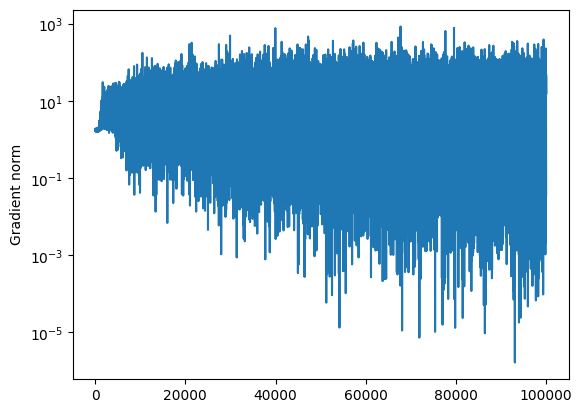

In [24]:
plt.plot(gradient_norm)
plt.yscale('log')
plt.ylabel("Gradient norm");

## Optional Task



Refactor the RNN to use the standard PyTorch layer `nn.RNN` as it was used in the lecture!
Note that this also requires to adapt the `train`  and `eval` function.

